<font size="+3"><strong> Random Forest Classification  </strong></font>

In [ ]:
# Import libraries
import json
import pickle

import matplotlib.pyplot as plt
import pandas as pd

from imblearn.over_sampling import RandomOverSampler
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.pipeline import make_pipeline

# Prepare Data

## Import

In [ ]:
def wrangle(filename):
      """
      The function takes the name of a decompressed file as input and returns a tidy DataFrame

      Parameters
      ----------

      filename : str
        The name of a decompressed JSON file

      Returns
      -------
      df : dataframe

      """
      #open decompressed file, load into dict
      with open (filename, "r") as f:
              data = json.load(f)
      # Turn dict into DataFrame
      df = pd.DataFrame().from_dict(data["data"]).set_index("id")

      return df

In [ ]:
# Read the data into dataframe `df`
df = wrangle("taiwan-bankruptcy-data.json")
print(df.shape)
df.head()

(6819, 96)


,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,feat_10,...,feat_87,feat_88,feat_89,feat_90,feat_91,feat_92,feat_93,feat_94,feat_95,bankrupt
id,,,,,,,,,,,,,,,,,,,,,
1,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,0.780985,...,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,1,0.016469,True
2,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,0.781506,...,0.008323,0.623652,0.610237,0.839969,0.283846,0.264577,0.570175,1,0.020794,True
3,0.426071,0.499019,0.472295,0.601450,0.601364,0.998857,0.796403,0.808388,0.302035,0.780284,...,0.040003,0.623841,0.601449,0.836774,0.290189,0.026555,0.563706,1,0.016474,True
4,0.399844,0.451265,0.457733,0.583541,0.583541,0.998700,0.796967,0.808966,0.303350,0.781241,...,0.003252,0.622929,0.583538,0.834697,0.281721,0.026697,0.564663,1,0.023982,True
5,0.465022,0.538432,0.522298,0.598783,0.598783,0.998973,0.797366,0.809304,0.303475,0.781550,...,0.003878,0.623521,0.598782,0.839973,0.278514,0.024752,0.575617,1,0.035490,True


## Split

In [ ]:
# Create our feature matrix `X` and target vector `y`
target = "bankrupt"
X = df.drop(columns= target)
y = df[target]
print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (6819, 95)
y shape: (6819,)


In [ ]:
# Divide our data (X and y) into training and test sets using a randomized train-test-split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (5455, 95)
y_train shape: (5455,)
X_test shape: (1364, 95)
y_test shape: (1364,)


## Resample

In [ ]:
# Create a new feature matrix `X_train_over` and target vector `y_train_over` by performing random over-sampling on our training data
over_sampler = RandomOverSampler(random_state=42)
X_train_over, y_train_over = over_sampler.fit_resample(X_train, y_train)
print("X_train_over shape:", X_train_over.shape)
X_train_over.head()
print("y_train_over:", y_train_over.shape)

X_train_over shape: (10572, 95)
y_train_over: (10572,)


# Build Model

## Baseline

In [ ]:
# Calculate the baseline accuracy score for our model
acc_baseline = y_train.value_counts(normalize=True).max()
print("Baseline Accuracy:", round(acc_baseline, 4))

Baseline Accuracy: 0.969


## Iterate

In [ ]:
# Create a pipeline named clf that contains a `SimpleImputer` transformer and a `RandomForestClassifier` predictor
clf = make_pipeline(SimpleImputer(), RandomForestClassifier(random_state=42))
print(clf)

Pipeline(steps=[('simpleimputer', SimpleImputer()),
                ('randomforestclassifier',
                 RandomForestClassifier(random_state=42))])


In [ ]:
# Perform cross-validation with our classifier, using the over-sampled training data
cv_acc_scores = cross_val_score(clf, X_train_over, y_train_over, cv = 5, n_jobs= -1)
print(cv_acc_scores)

[0.99338061 0.99432624 0.99432356 0.99668874 0.99432356]


In [ ]:
"""
Create a dictionary with the range of hyperparameters that we want to evaluate for our classifier:
       1. For the SimpleImputer, try both the "mean" and "median" strategies.
       2. For the RandomForestClassifier, try max_depth settings between 10 and 15, by steps of 10.
       3. Also for the RandomForestClassifier, try n_estimators settings between 25 and 100 by steps of 25.
"""
params = {
    "simpleimputer__strategy":["mean","median"],
    "randomforestclassifier__n_estimators":range(25,100,25),
    "randomforestclassifier__max_depth":range(10,50,10)
}
params

{'simpleimputer__strategy': ['mean', 'median'],
 'randomforestclassifier__n_estimators': range(25, 100, 25),
 'randomforestclassifier__max_depth': range(10, 50, 10)}

In [ ]:
# Create a `GridSearchCV` named model that includes our classifier and hyperparameter grid
model = GridSearchCV(
     clf,
     param_grid=params,
     cv=5,
     n_jobs=-1,
     verbose=1
)
model

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('simpleimputer', SimpleImputer()),
                                       ('randomforestclassifier',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'randomforestclassifier__max_depth': range(10, 50, 10),
                         'randomforestclassifier__n_estimators': range(25, 100, 25),
                         'simpleimputer__strategy': ['mean', 'median']},
             verbose=1)

In [ ]:
# Train model
model.fit(X_train_over, y_train_over)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('simpleimputer', SimpleImputer()),
                                       ('randomforestclassifier',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'randomforestclassifier__max_depth': range(10, 50, 10),
                         'randomforestclassifier__n_estimators': range(25, 100, 25),
                         'simpleimputer__strategy': ['mean', 'median']},
             verbose=1)

In [ ]:
# Extract the cross-validation results from model and load them into a DataFrame
cv_results = pd.DataFrame(model.cv_results_)
cv_results.head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_randomforestclassifier__max_depth,param_randomforestclassifier__n_estimators,param_simpleimputer__strategy,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,1.206468,0.113230,0.025231,0.001814,10,25,mean,"{'randomforestclassifier__max_depth': 10, 'ran...",0.979196,0.977778,0.980132,0.978713,0.979659,0.979096,0.000811,21
1,1.246494,0.017706,0.029614,0.007617,10,25,median,"{'randomforestclassifier__max_depth': 10, 'ran...",0.979196,0.977778,0.980132,0.978713,0.979659,0.979096,0.000811,21
2,2.447735,0.566220,0.044289,0.012441,10,50,mean,"{'randomforestclassifier__max_depth': 10, 'ran...",0.979669,0.979196,0.980132,0.979186,0.979186,0.979474,0.000378,19
3,2.505950,0.541822,0.034082,0.001857,10,50,median,"{'randomforestclassifier__max_depth': 10, 'ran...",0.979669,0.979196,0.980132,0.979186,0.979186,0.979474,0.000378,19
4,3.715686,0.713764,0.050551,0.016531,10,75,mean,"{'randomforestclassifier__max_depth': 10, 'ran...",0.979196,0.980142,0.977294,0.979659,0.978713,0.979001,0.000977,23
5,3.239044,0.041967,0.041567,0.001889,10,75,median,"{'randomforestclassifier__max_depth': 10, 'ran...",0.979196,0.980142,0.977294,0.979659,0.978713,0.979001,0.000977,23
6,1.908518,0.392376,0.042108,0.018575,20,25,mean,"{'randomforestclassifier__max_depth': 20, 'ran...",0.985816,0.985816,0.990066,0.988647,0.988647,0.987798,0.001700,17
7,1.451321,0.024955,0.026317,0.000900,20,25,median,"{'randomforestclassifier__max_depth': 20, 'ran...",0.985816,0.985816,0.990066,0.988647,0.988647,0.987798,0.001700,17
8,2.917685,0.434603,0.046699,0.014482,20,50,mean,"{'randomforestclassifier__max_depth': 20, 'ran...",0.987234,0.987707,0.989120,0.990066,0.987701,0.988366,0.001060,15
9,2.922371,0.458655,0.034428,0.000303,20,50,median,"{'randomforestclassifier__max_depth': 20, 'ran...",0.987234,0.987707,0.989120,0.990066,0.987701,0.988366,0.001060,15


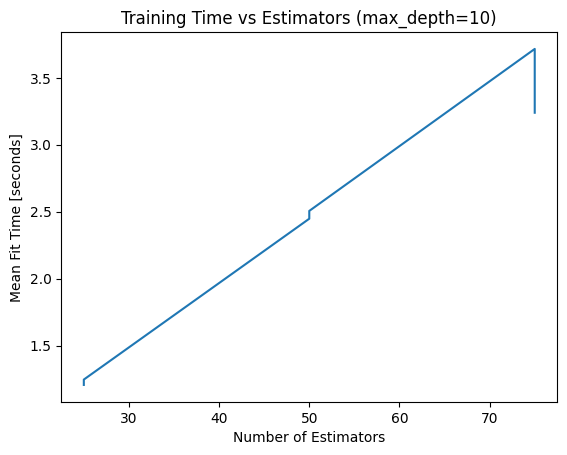

In [ ]:
"""
 Take a closer look at how different hyperparameter settings affect training time
    1. Look at models where `max_depth` equals 10
"""
# Create mask
mask = cv_results["param_randomforestclassifier__max_depth"]==10

# Plot fit time vs n_estimators
plt.plot(
    cv_results[mask]["param_randomforestclassifier__n_estimators"],
    cv_results[mask]["mean_fit_time"]
)

# Label axes
plt.xlabel("Number of Estimators")
plt.ylabel("Mean Fit Time [seconds]")
plt.title("Training Time vs Estimators (max_depth=10)");

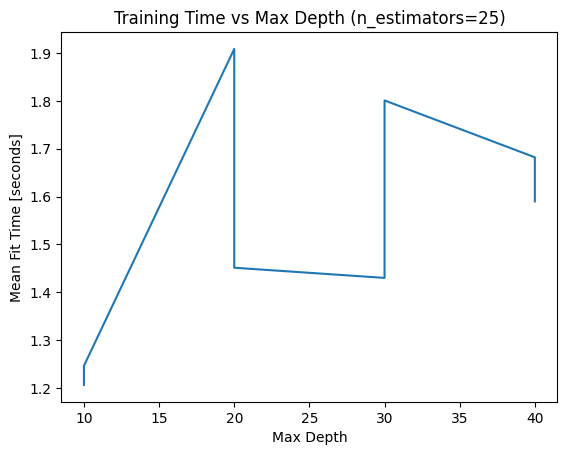

In [ ]:
"""
 Take a closer look at how different hyperparameter settings affect training time
    2. look at `max_depth` with limit our data to rows where `n_estimators` equals 25
"""

# Create mask
mask = cv_results["param_randomforestclassifier__n_estimators"]==25

# Plot fit time vs max_depth
plt.plot(
    cv_results[mask]["param_randomforestclassifier__max_depth"],
    cv_results[mask]["mean_fit_time"]
)

# Label axes
plt.xlabel("Max Depth")
plt.ylabel("Mean Fit Time [seconds]")
plt.title("Training Time vs Max Depth (n_estimators=25)");

In [ ]:
# Extract best hyperparameters
model.best_params_

{'randomforestclassifier__max_depth': 40,
 'randomforestclassifier__n_estimators': 50,
 'simpleimputer__strategy': 'mean'}

## Evaluate

In [ ]:
# Calculate the training and test accuracy scores for `model`
acc_train = model.score(X_train_over, y_train_over)
acc_test = model.score(X_test, y_test)
print("Training Accuracy:", round(acc_train, 4))
print("Test Accuracy:", round(acc_test, 4))

Training Accuracy: 1.0
Test Accuracy: 0.9663


In [ ]:
# Count how many observations in our test set belong to the positive and negative classes
y_test.value_counts()

False    1313
True       51
Name: bankrupt, dtype: int64

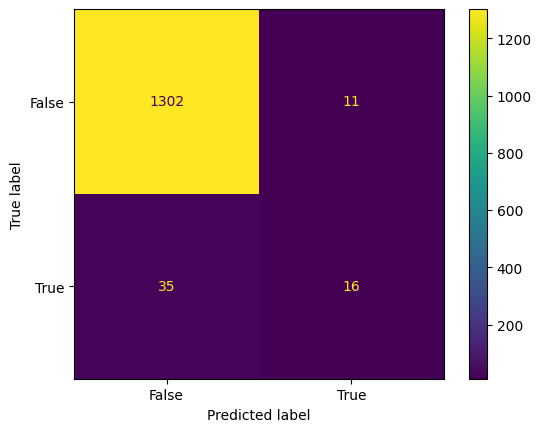

In [ ]:
# Plot confusion matrix
ConfusionMatrixDisplay.from_estimator(model, X_test, y_test);

# Results

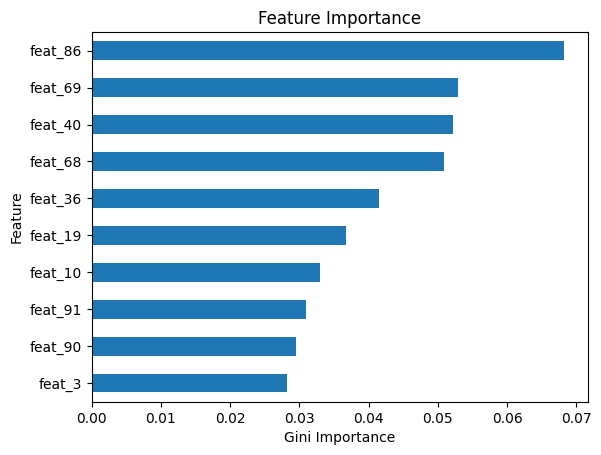

In [ ]:
"""
 Create a horizontal bar chart with the 15 most important features for `model_over.`
"""

# Get feature names from training data
features = X_train_over.columns

# Extract importances from model
importances = model.best_estimator_.named_steps["randomforestclassifier"].feature_importances_

# Create a series with feature names and importances
feat_imp = pd.Series(importances, index= features).sort_values()

# Plot 10 most important features
feat_imp.tail(10).plot(kind= "barh")

plt.xlabel("Gini Importance")
plt.ylabel("Feature")
plt.title("Feature Importance");

In [ ]:
# Save model
with open("model-2.pkl", "wb") as f:
     pickle.dump(model, f)

In [ ]:
def make_predictions(data_filepath, model_filepath):
     """
     The function takes the name of a decompressed file as input and returns a tidy DataFrame

     Parameters
     ----------

     data_filepath : str
       the path of a JSON file that contains test data

     model_filepath : str
       the path of a serialized model

     Returns
     -------
     predictions : series

     """

     # Wrangle JSON file
     X_test = wrangle(data_filepath)

     # Load model
     with open(model_filepath, "rb") as f:
           model = pickle.load(f)

     # Generate predictions
     y_test_pred = model.predict(X_test)

     # Put predictions into Series with name "bankrupt", and same index as X_test
     y_test_pred = pd.Series(y_test_pred, index = X_test.index, name ="bankrupt")

     return y_test_pred

In [ ]:
y_test_pred = make_predictions(
     data_filepath="taiwan-bankruptcy-data-test-features.json",
     model_filepath="model-2.pkl",
)
print("predictions shape:", y_test_pred.shape)
y_test_pred.head()

predictions shape: (682,)


id
18    False
20    False
24    False
32     True
38    False
Name: bankrupt, dtype: object